In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from utils import plot_joint_distribution
# import matplotlib
# matplotlib.rc('xtick',labelsize = 20)
# matplotlib.rc('ytick',labelsize = 20)

def ProximalPointOT(mu, nv, C, beta = 2, maxiter = 1000, inner_maxiter = 1, use_path = True, return_map = True, return_loss = True):
    n = len(mu)
    a = np.ones([n,])
    b = a
    T = np.ones((n,n))/n**2
    G = np.exp(-(C/beta))
    loss = []
    for outer_iter in range(maxiter):
        Q = G * T
        for inner_iter in range(inner_maxiter):
            a = mu/(np.matmul(Q,b) + 1e-3)
            b = nv/(np.matmul(np.transpose(Q),a) + 1e-3)
        T = np.expand_dims(a,axis = 1)*Q*np.expand_dims(b,axis = 0)
        WD = np.sum(T*C)
        loss.append(WD)
    return T,loss

np.random.seed(123456)

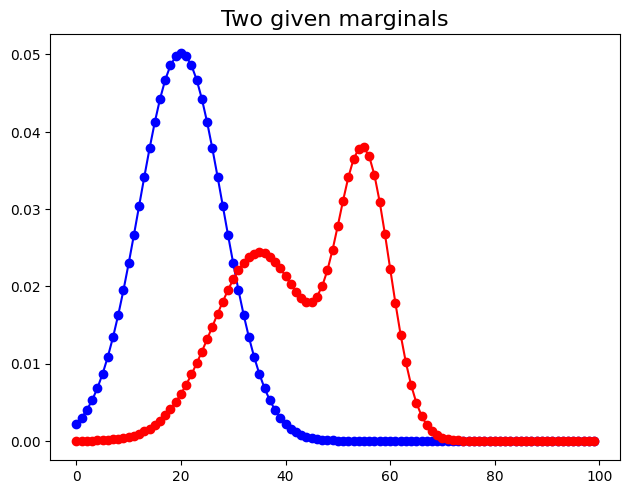

/home/ljb/miniforge3/envs/sbp/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


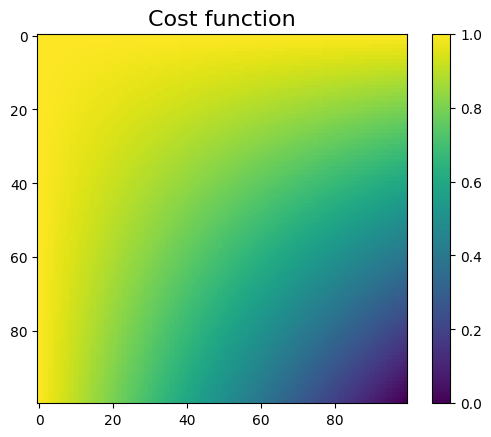

0.0
2.3177543356889258437e-1070
0.91986818238621767774


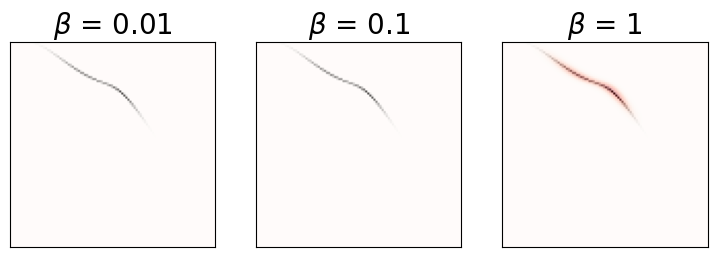

done


In [2]:
## numerical expertiments
colors=['k','b','g','r']

n = 100
x = np.arange(n,dtype = np.float128)

p1 = ot.datasets.get_1D_gauss(n,20,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)
p2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)

plt.plot(x,p1,'o-',color='blue')
plt.plot(x,p2,'o-',color='red')
plt.tight_layout()
plt.title('Two given marginals', fontsize=16)
plt.show()

# ## c = -xy
c = -x*np.expand_dims(x,axis=1)
c = (c-c.min())/(c.max()-c.min())
# c =  c - c.min() + 10
# c/=c.max()



# print(c)
plt.imshow(c)
plt.colorbar()
# plt.clim(0, 1)
plt.title('Cost function', fontsize=16)
plt.show()

T_emd = ot.emd(p1,p2,c)
ground_truth = np.sum(T_emd*c)

maxiter = 2000
beta_list = [0.01,0.1,1]
inner_maxiter = 1
use_path = True

### proximal point OT
T_pp_list  = []
loss_pp_list = []

for beta in beta_list:
    # T, loss = fpot.fpot_wd(p1, p2, C, beta=beta, maxiter=maxiter, inner_maxiter=inner_maxiter, use_path=use_path)
    T,loss = ProximalPointOT(p1,p2,c,beta = beta, maxiter = maxiter, inner_maxiter = inner_maxiter, use_path = use_path)
    print(T.sum())
    loss_pp_list.append(loss)
    T_pp_list.append(T)
### colormap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('Reds')
new_cmap = truncate_colormap(cmap, 0., 0.8)


f,axarr = plt.subplots(1,len(beta_list),figsize = (9,3))
for i, beta in enumerate(beta_list):
    axarr[i].imshow(T_pp_list[i],cmap = new_cmap)
    axarr[i].imshow(T_emd,cmap = plt.get_cmap('binary'),alpha = 0.7)
    axarr[i].xaxis.set_ticks([])
    axarr[i].yaxis.set_ticks([])
    axarr[i].set_title(r'$\beta$ = ' + str(beta), fontsize = 20)
plt.show()

print('done')

# Wasserstein-SBP

$$
\begin{aligned}
\min _\gamma & \mathbb{E}_{\left(x_1, x_2, x_3, x_4\right) \sim \gamma}\left[d\left(\left(x_1, x_2\right),\left(x_3, x_4\right)\right)\right] \\
\text { s.t. } & \operatorname{Proj}_{1 \#} \gamma=\pi_1, \operatorname{Proj}_{2 \#} \gamma=\pi_2, \operatorname{Proj}_{3,4 \#} \gamma=\mathbb{Q}_0
\end{aligned}
$$

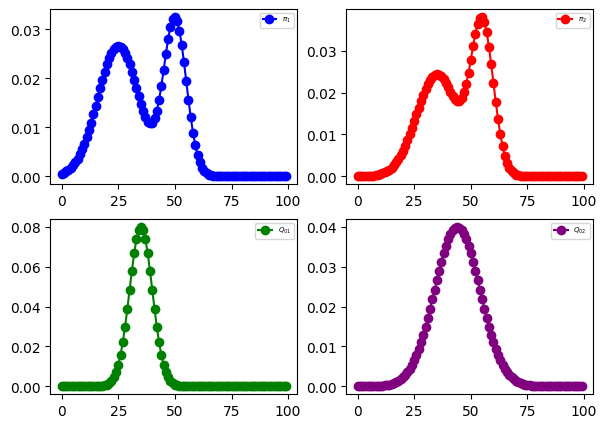

In [3]:

# pi_1 = ot.datasets.get_1D_gauss(n,30,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)
pi_1 = 0.6 * ot.datasets.get_1D_gauss(n,25,9) + 0.4 * ot.datasets.get_1D_gauss(n,50,5)
pi_2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)

Q_01 = ot.datasets.get_1D_gauss(n,35,5)
Q_02 = ot.datasets.get_1D_gauss(n,44,10)

# Q_0 is the joint distribution of Q_01 and Q_02
Q_0 = np.outer(Q_01, Q_02)

fig, axs = plt.subplots(2, 2, figsize=(7, 5))
axs[0][0].plot(x, pi_1, 'o-', color='blue', label='$\pi_1$')
axs[0][1].plot(x, pi_2, 'o-', color='red', label='$\pi_2$')
axs[0][0].legend(fontsize=5)
axs[0][1].legend(fontsize=5)
# fig.tight_layout()

axs[1][0].plot(x, Q_01, 'o-', color='green', label='$Q_{01}$')
axs[1][1].plot(x, Q_02, 'o-', color='purple', label='$Q_{02}$')
axs[1][0].legend(fontsize=5)
axs[1][1].legend(fontsize=5)
# fig.tight_layout()

plt.show()

In [4]:
n = len(pi_1)

# 创建 x1 和 x3 的值
x1_values = np.arange(n,dtype=np.float128).reshape(n, 1)  # 转换为列向量
x3_values = np.arange(n,dtype=np.float128).reshape(1, n)  # 转换为行向量

# 使用 NumPy 的广播计算成本矩阵
c2 = -np.dot(x1_values, x3_values)
c2 = (c2 - c2.min())/(c2.max() - c2.min())

gamma_a,loss = ProximalPointOT(pi_1,Q_01,c2,beta=1,maxiter=100,inner_maxiter=1)
gamma_a = gamma_a/gamma_a.sum()
print(gamma_a.sum(),loss[-1])
# plt.plot(loss)
gamma_b,loss = ProximalPointOT(Q_02,pi_2,c2,beta=1,maxiter=100,inner_maxiter=1)
gamma_b = gamma_b/gamma_b.sum()
print(gamma_b.sum(),loss[-1])
# plt.plot(loss)

1.0 0.81128658203702461746
1.0 0.72354082109179034855


/home/ljb/miniforge3/envs/sbp/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)


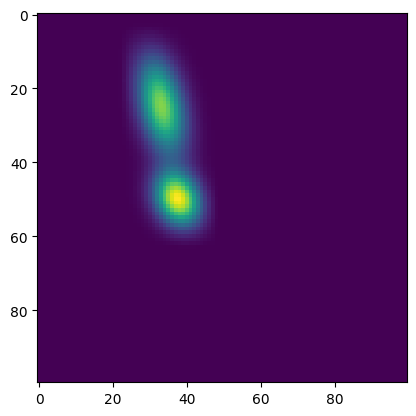

In [5]:
plt.imshow(gamma_a)

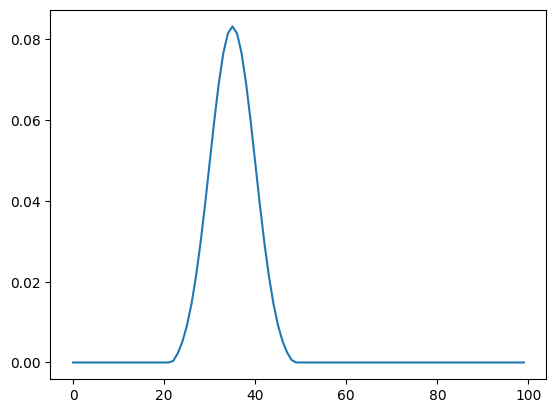

In [6]:
plt.plot(gamma_a.sum(axis=0))

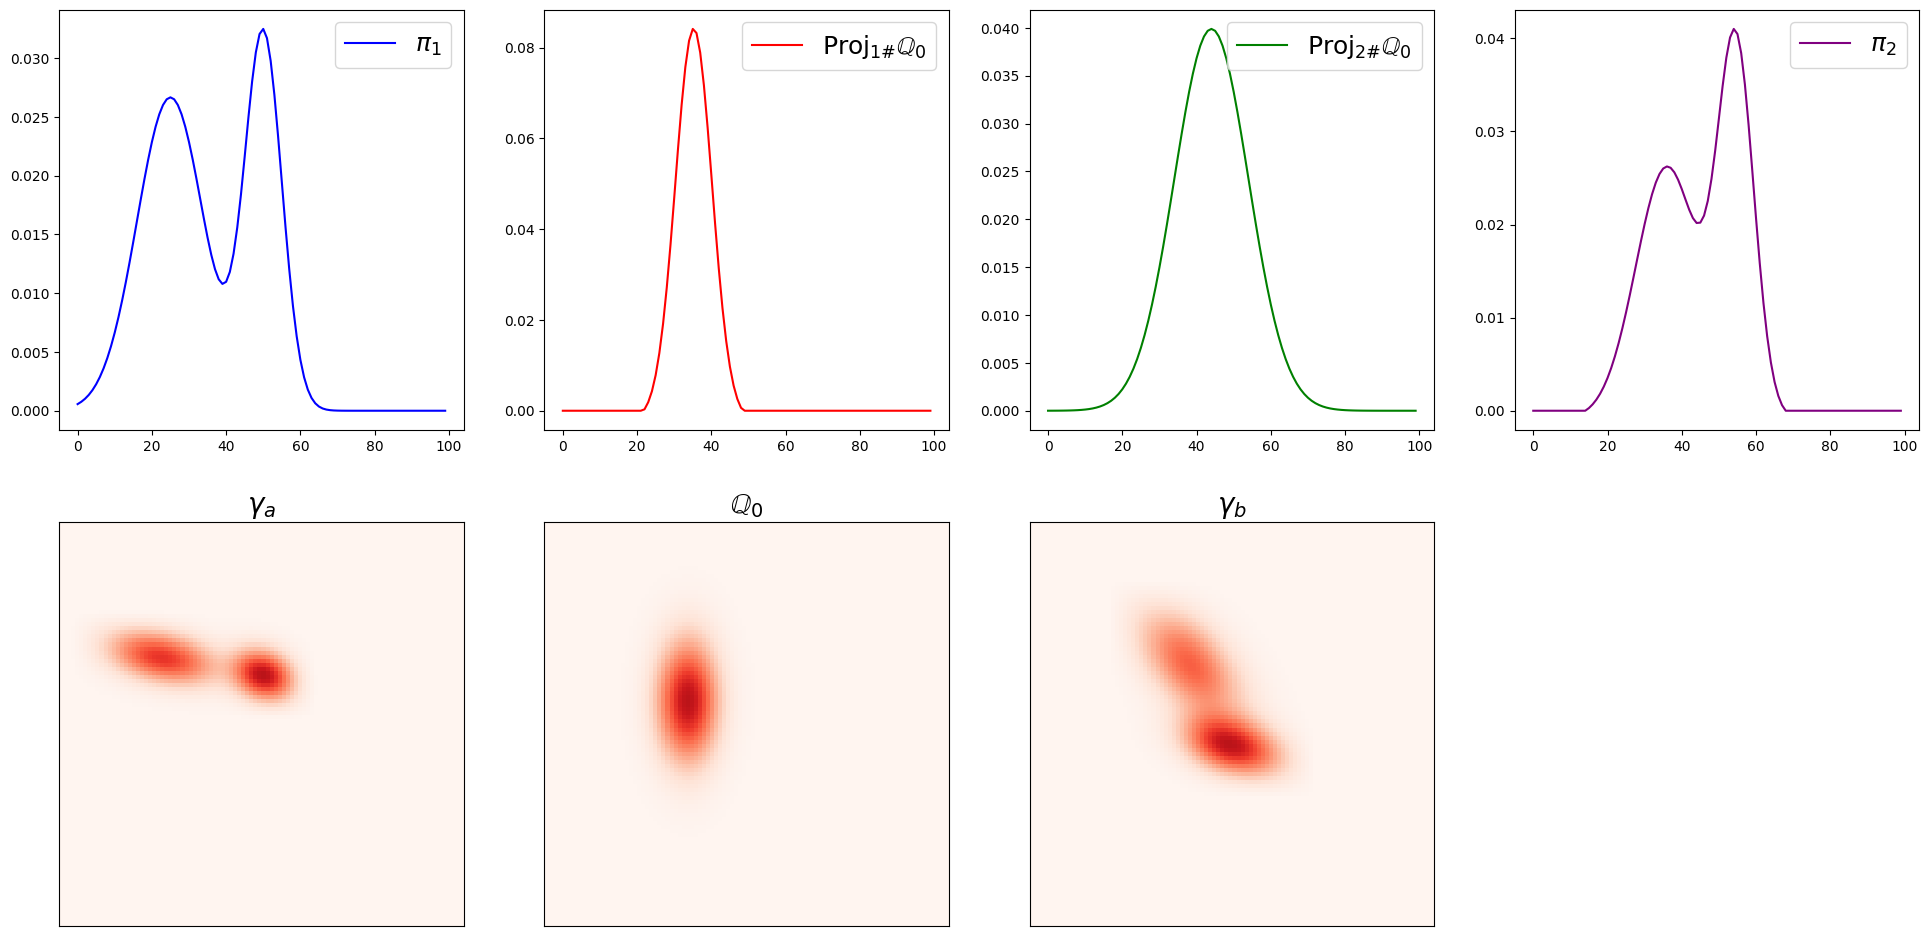

In [7]:

fig,axs = plt.subplots(2,4,figsize = (24,12))
axs[0][0].plot(x, pi_1, '-', color='blue', label='$\pi_1$')
cal_Q_01 = np.dot(pi_1, gamma_a)
cal_Q_01 = cal_Q_01 / cal_Q_01.sum()
axs[0][1].plot(x, cal_Q_01, '-', color='red', label=r'$\text{Proj}_{1\#}\mathbb{Q}_{0}$')
cal_Q_02 = np.dot(cal_Q_01,Q_0)
cal_Q_02 = cal_Q_02 / cal_Q_02.sum()
axs[0][2].plot(x, cal_Q_02, '-', color='green', label=r'$\text{Proj}_{2\#}\mathbb{Q}_{0}$')
cal_pi_2 = np.dot(cal_Q_02,gamma_b)
cal_pi_2 = cal_pi_2 / cal_pi_2.sum()
axs[0][3].plot(x, cal_pi_2, '-', color='purple', label='$\pi_2$')
axs[0][0].legend(fontsize=18)
axs[0][1].legend(fontsize=18)
axs[0][2].legend(fontsize=18)
axs[0][3].legend(fontsize=18)

axs[1][0].imshow(gamma_a.astype(np.float64).T,cmap = new_cmap)
axs[1][1].imshow(Q_0.astype(np.float64).T,cmap = new_cmap)
axs[1][2].imshow(gamma_b.astype(np.float64).T,cmap = new_cmap)

axs[1][0].set_title(r'$\gamma_{a}$', fontsize = 20)
axs[1][1].set_title(r'$\mathbb{Q}_{0}$', fontsize = 20)
axs[1][2].set_title(r'$\gamma_{b}$', fontsize = 20)

# remove the x and y axis outilers  
axs[1][0].get_xaxis().set_visible(False)
axs[1][0].get_yaxis().set_visible(False)
axs[1][1].get_xaxis().set_visible(False)
axs[1][1].get_yaxis().set_visible(False)
axs[1][2].get_xaxis().set_visible(False)
axs[1][2].get_yaxis().set_visible(False)
axs[1][3].set_visible(False)

fig.show()
fig.savefig('output/separable_case.pdf', bbox_inches='tight')

(<Figure size 1000x1000 with 3 Axes>, <Axes: >)

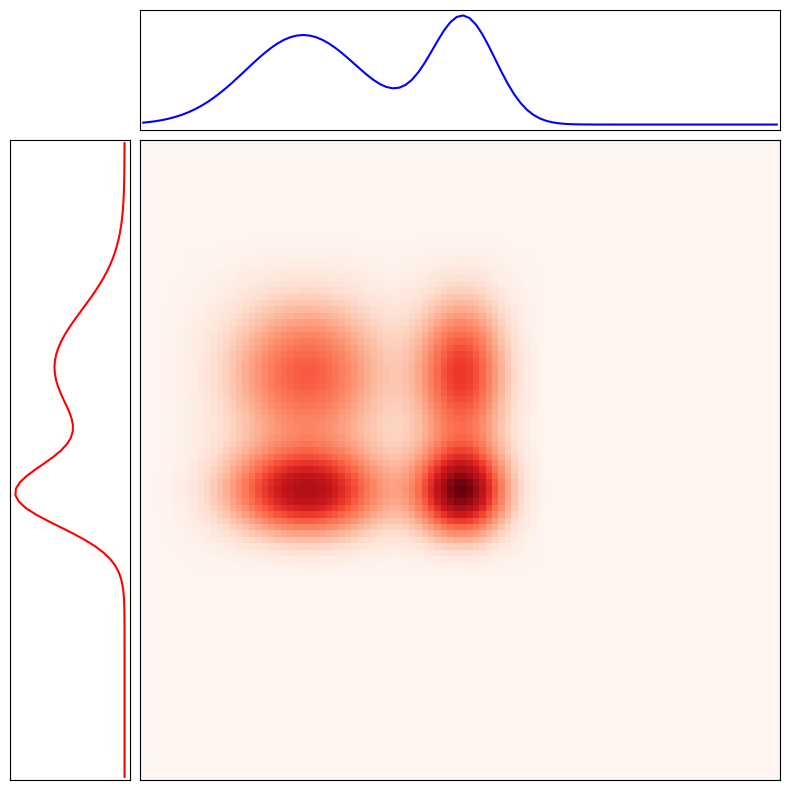

In [16]:
tilde_gamma = np.einsum('ij,jk,kl->il', gamma_a, Q_0, gamma_b)

plot_joint_distribution(tilde_gamma, pi_1, pi_2, save_dir='output/separable_case_tilde_gamma.pdf')
# plot_plot_joint_distribution(tilde_gamma, pi_1, pi_2)
# plot_plot_joint_distribution(tilde_gamma)

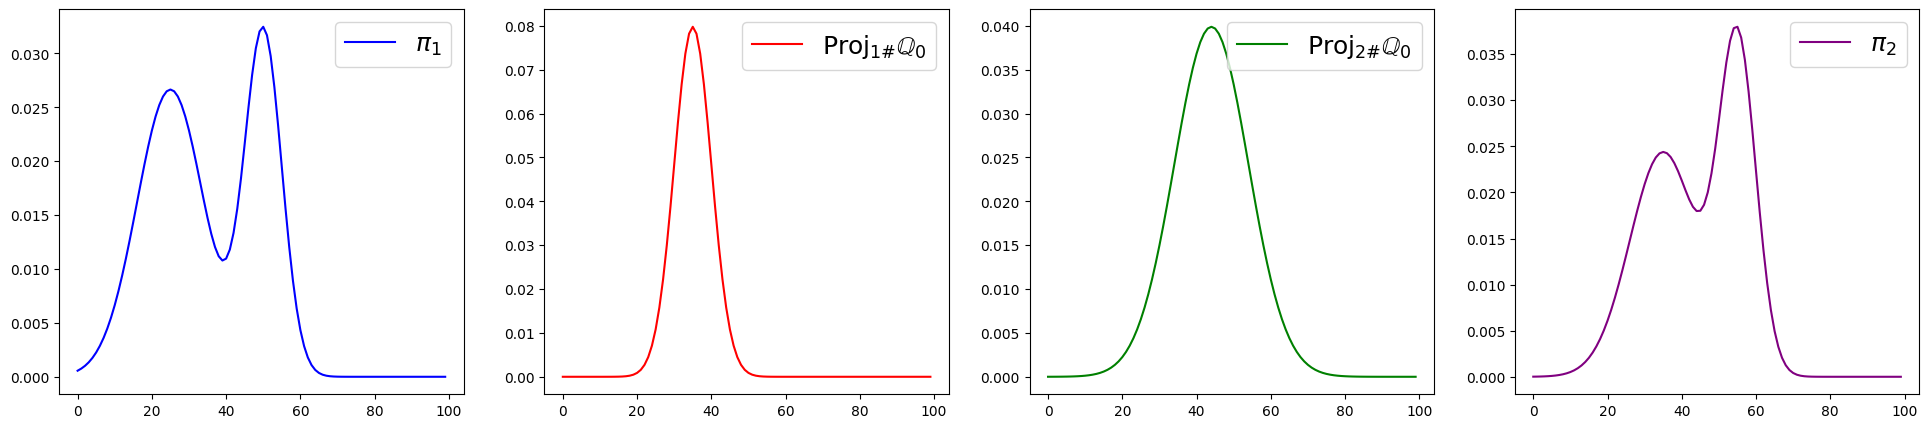

In [9]:

fig,axs = plt.subplots(1,4,figsize = (24,5))
axs[0].plot(x, pi_1, '-', color='blue', label='$\pi_1$')
axs[1].plot(x, Q_01, '-', color='red', label=r'$\text{Proj}_{1\#}\mathbb{Q}_{0}$')
axs[2].plot(x, Q_02, '-', color='green', label=r'$\text{Proj}_{2\#}\mathbb{Q}_{0}$')
axs[3].plot(x, pi_2, '-', color='purple', label='$\pi_2$')
axs[0].legend(fontsize=18)
axs[1].legend(fontsize=18)
axs[2].legend(fontsize=18)
axs[3].legend(fontsize=18)
fig.show()
fig.savefig('output/separable_case_target.pdf')

In [10]:
def geometricBar(weights, alldistribT):
    """return the weighted geometric mean of distributions"""
    assert (len(weights) == alldistribT.shape[1])
    return np.exp(np.dot(np.log(alldistribT), weights.T))


def geometricMean(alldistribT):
    """return the  geometric mean of distributions"""
    return np.exp(np.mean(np.log(alldistribT), axis=1))

### Sinkhorn type algo for OT Barycenter
def barycenter_sinkhorn(marginals, cost, epsilon, weights = None, maxiter=1000, stopThr=1e-4):

    K = np.exp(-cost/epsilon)
    cpt = 0
    err = 1
    vT = np.divide(marginals.T, np.sum(K, axis=0))
    UKv = np.dot(K, vT.T)
    u = (geometricMean(UKv) / UKv.T).T

    ###
    # u = np.ones((100,2))
    ###
    while (cpt < maxiter):# err > stopThr and
        cpt = cpt + 1
        Ku = np.dot(K, u)
        v = np.divide(marginals, Ku)
        Kv = np.dot(K,v)
        UKv = u*Kv
        # UKv = u * np.dot(K, np.divide(marginals, np.dot(K, u)))
        u = (u.T * geometricBar(weights, UKv)).T / UKv

    return geometricBar(weights, UKv)


def calculate_n_barycenter_sinkhorn(marginals, cost, epsilon, maxiter, num_timepoints):
    ret = []
    for time_idx in range(num_timepoints):  # 0<=alpha<=1
        alpha = time_idx/num_timepoints
        weights = np.array([1-alpha, alpha])

        barycenter1 = barycenter_sinkhorn(marginals, cost, epsilon=epsilon, weights=weights, maxiter=maxiter)
        ret.append(barycenter1.reshape(1, -1))
    return np.concatenate(ret, axis=0)

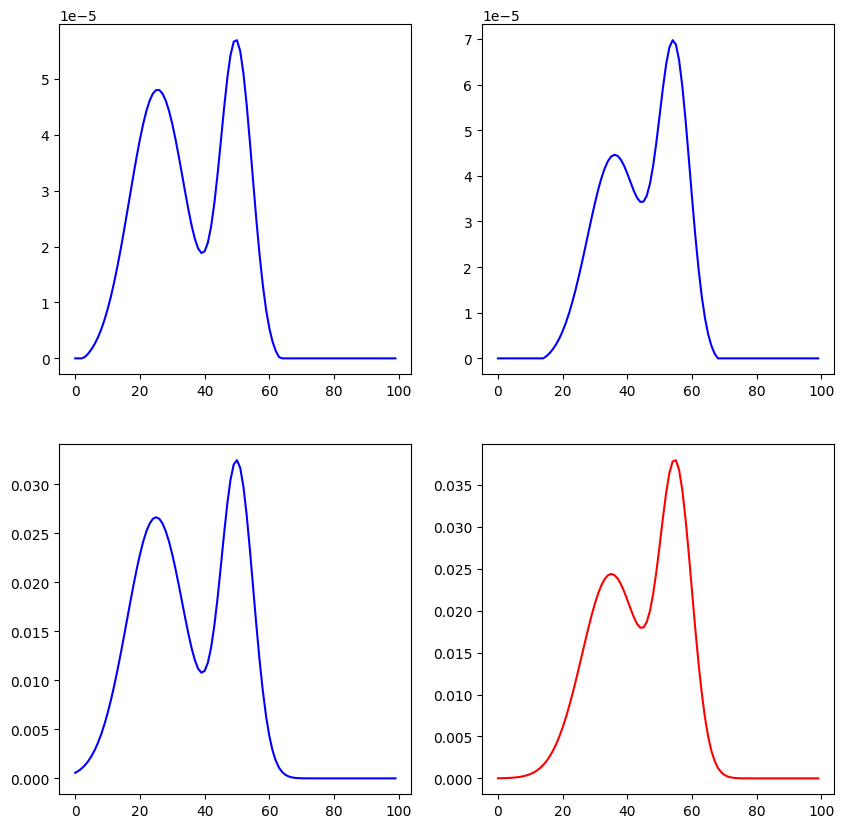

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(x, tilde_gamma.sum(axis=1), '-', color='blue')
axs[0][1].plot(x, tilde_gamma.sum(axis=0), '-', color='blue')

axs[1][0].plot(x, pi_1, '-', color='blue')
axs[1][1].plot(x, pi_2, '-', color='red')

In [12]:
# cost = np.absolute(x - np.expand_dims(x, axis=1))
# cost = np.power(cost, 2)
# barycenter_ret_1 = calculate_n_barycenter_sinkhorn(np.vstack((pi_1, cal_Q_01)).T, cost, 0.001, maxiter=1000, num_timepoints=20)
# barycenter_ret_2 = calculate_n_barycenter_sinkhorn(np.vstack((cal_Q_02, pi_2)).T, cost, 0.001, maxiter=1000, num_timepoints=20)

In [13]:
def plot_gamma(gamma,ax):
    ax.imshow(gamma,cmap = new_cmap)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

In [14]:
# # 计算边缘分布
# margin_x = Q_02  # y的边缘分布
# margin_y = Q_01  # x的边缘分布

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # plt.figure(figsize=(10, 10))
# fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# axs[0].plot

# axs[1].get_xaxis().set_visible(False)
# axs[1].get_yaxis().set_visible(False)
# divider = make_axes_locatable(axs[1])

# # 创建额外的轴
# ax_x = divider.append_axes("top", size=1.2, pad=0.1, sharex=axs[1])
# ax_y = divider.append_axes("left", size=1.2, pad=0.1, sharey=axs[1])

# # 热力图
# cax = axs[1].imshow(Q_0.T,)

# # 绘制边缘分布
# ax_x.plot(range(n), margin_y, color='blue')
# ax_y.plot(-margin_x, range(n), color='red')

# # 设置轴的属性
# ax_x.get_xaxis().set_visible(False)
# ax_x.get_yaxis().set_visible(False)
# ax_y.get_xaxis().set_visible(False)
# ax_y.get_yaxis().set_visible(False)
# axs[1].set_xticks(range(n))
# axs[1].set_yticks(range(n))

# plt.show()